In [ ]:
%matplotlib inline
from __future__ import print_function, division

from tensorflow import keras
import keras
from keras.datasets import cifar10
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, GaussianNoise, Permute, Conv2DTranspose
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D, Concatenate
from keras.layers import MaxPooling2D
from tensorflow.keras import activations
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras import losses
import keras.backend as K
from keras.models import *

import matplotlib.pyplot as plt
from functools import partial
import numpy as np
import random
import math
import cv2 as cv

## Models architecture

In [ ]:
# before starting run the model make sure you have a shortcut to the folder Deep_Learning_Project
# from your drive - meaning in the folder MyDrive you will see the Deep_Learning_Project folder.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# weights pathes
drive_base_path = "/content/drive/MyDrive/Deep_Learning_Project"
weights_dir = "models_weights"

CENTRAL_BLOCK_PHOTOS_WEIGHTS_PATH = f"{drive_base_path}/{weights_dir}/central_block_photos_weights.hdf5" 
BLOCKS_PHOTOS_WEIGHTS_PATH = f"{drive_base_path}/{weights_dir}/blocks_photos_weights.hdf5"
REGION_PHOTOS_WEIGHTS_PATH = f"{drive_base_path}/{weights_dir}/region_photos_weights.hdf5"

CENTRAL_BLOCK_MONET_WEIGHTS_PATH =  f"{drive_base_path}/{weights_dir}/central_block_monet_weights.hdf5" 
BLOCKS_MONET_WEIGHTS_PATH =  f"{drive_base_path}/{weights_dir}/blocks_monet_weights.hdf5" 
REGION_MONET_WEIGHTS_PATH =  f"{drive_base_path}/{weights_dir}/region_monet_weights.hdf5" 

MONET_CLASSIFIER_WEIGHTS_PATH = f"{drive_base_path}/{weights_dir}/monet_classifier_weights.hdf5"
MASK_CLASSIFIER_WEIGHTS_PATH = f"{drive_base_path}/{weights_dir}/mask_classifier_weights.hdf5"

### context encoder

In [ ]:
class ContextEncoder():
    def __init__(self):
        self.img_rows = 256
        self.img_cols = 256
        self.mask_height = 128
        self.mask_width = 128
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)

        # Build the generator
        self.generator = self.build_generator()
        self.generator.compile(loss='mse', optimizer='adam')

        masked_img = Input(shape=self.img_shape)
        gen_missing = self.generator(masked_img)



    def build_generator(self):

        X_input = Input(shape=self.img_shape)
        X_shortcut = X_input

        # encoder
        X = Conv2D(64, kernel_size=4, strides=1, input_shape=self.img_shape, padding="same", name='conv_1')(X_input)
        X = LeakyReLU(alpha=0.2, name='conv_1_leakyRelu')(X)
        X = BatchNormalization(momentum=0.8, name='conv_1_batchnorm')(X)
        end_conv1 = MaxPooling2D(pool_size=(2, 2), padding='same')(X)
        
        X = Conv2D(64, kernel_size=4, strides=1, padding="same", name='conv_2')(end_conv1)
        X = LeakyReLU(alpha=0.2, name='conv_2_leakyRelu')(X)
        X = BatchNormalization(momentum=0.8, name='conv_2_batchnorm')(X)
        end_conv2 = MaxPooling2D(pool_size=(2, 2), padding='same')(X)
        
        X = Conv2D(128, kernel_size=4, strides=1, padding="same", name='conv_3')(end_conv2)
        X = LeakyReLU(alpha=0.2, name='conv_3_leakyRelu')(X)
        X = BatchNormalization(momentum=0.8, name='conv_3_batchnorm')(X)
        end_conv3 = MaxPooling2D(pool_size=(2, 2), padding='same')(X)
        
        X = Conv2D(256, kernel_size=4, strides=1, padding="same", name='conv_4')(end_conv3)
        X = LeakyReLU(alpha=0.2, name='conv_4_leakyRelu')(X)
        X = BatchNormalization(momentum=0.8, name='conv_4_batchnorm')(X)
        end_conv4 = MaxPooling2D(pool_size=(2, 2), padding='same')(X)
        
        X = Conv2D(512, kernel_size=4, strides=1, padding="same", name='conv_5')(end_conv4)
        X = LeakyReLU(alpha=0.2, name='conv_5_leakyRelu')(X)
        X = BatchNormalization(momentum=0.8, name='conv_5_batchnorm')(X)
        end_conv5 = MaxPooling2D(pool_size=(2, 2), padding='same')(X)
        
        # smart fully-connected
        X = Permute((3, 1, 2), input_shape=(8, 8, 512))(end_conv5)
        X = Reshape((1, 512, 64), input_shape=(512, 8, 8))(X)
        X = Conv2D(64, (1, 1), padding="same")(X)
        X = Reshape((512, 8, 8), input_shape=(1, 512, 64))(X)
        X = Permute((2, 3, 1), input_shape=(512, 8, 8))(X)
        X = Concatenate(axis=3)([X, end_conv5])
        
        # decoder
        X = UpSampling2D(size=(2, 2))(X)
        X = Conv2D(512, kernel_size=4, strides=1, padding="same", name='conv_5_d')(X)
        X = LeakyReLU(alpha=0.2, name='conv_5_leakyRelu_d')(X)
        X = BatchNormalization(momentum=0.8, name='conv_5_batchnorm_d')(X)
        X = Concatenate(axis=3)([X, end_conv4])
        
        X = UpSampling2D(size=(2, 2))(X)
        X = Conv2D(256, kernel_size=4, strides=1, padding="same", name='conv_4_d')(X)
        X = LeakyReLU(alpha=0.2, name='conv_4_leakyRelu_d')(X)
        X = BatchNormalization(momentum=0.8, name='conv_4_batchnorm_d')(X)
        X = Concatenate(axis=3)([X, end_conv3])
        
        X = UpSampling2D(size=(2, 2))(X)
        X = Conv2D(128, kernel_size=4, strides=1, padding="same", name='conv_3_d')(X)
        X = LeakyReLU(alpha=0.2, name='conv_3_leakyRelu_d')(X)
        X = BatchNormalization(momentum=0.8, name='conv_3_batchnorm_d')(X)
        X = Concatenate(axis=3)([X, end_conv2])

        X = UpSampling2D(size=(2, 2))(X)
        X = Conv2D(64, kernel_size=4, strides=1, padding="same", name='conv_2_d')(X)
        X = LeakyReLU(alpha=0.2, name='conv_2_leakyRelu_d')(X)
        X = BatchNormalization(momentum=0.8, name='conv_2_batchnorm_d')(X)
        X = Concatenate(axis=3)([X, end_conv1])
        
        X = UpSampling2D(size=(2, 2))(X)
        X = Conv2D(3, kernel_size=4, strides=1, input_shape=self.img_shape, padding="same", name='conv_last_d')(X)
        X = activations.sigmoid(X) # the output will be between 0 and 1
        
        return Model(inputs=X_input, outputs=X, name='auto-encoder')

In [ ]:
# regular photos conctext encoder

centeral_block_photos_model = ContextEncoder()
keras.Model.load_weights(centeral_block_photos_model.generator, filepath=CENTRAL_BLOCK_PHOTOS_WEIGHTS_PATH)

blocks_photos_model = ContextEncoder()
keras.Model.load_weights(blocks_photos_model.generator, filepath=BLOCKS_PHOTOS_WEIGHTS_PATH)

region_photos_model = ContextEncoder()
keras.Model.load_weights(region_photos_model.generator, filepath=REGION_PHOTOS_WEIGHTS_PATH)

In [ ]:
# Monet photos conctext encoder

centeral_block_monet_model = ContextEncoder()
keras.Model.load_weights(centeral_block_monet_model.generator, filepath=CENTRAL_BLOCK_MONET_WEIGHTS_PATH)

blocks_monet_model = ContextEncoder()
keras.Model.load_weights(blocks_monet_model.generator, filepath=BLOCKS_MONET_WEIGHTS_PATH)

region_monet_model = ContextEncoder()
keras.Model.load_weights(region_monet_model.generator, filepath=REGION_MONET_WEIGHTS_PATH)

### monet classifier

In [ ]:
class MonetClassifier():
    def __init__(self):
        self.img_shape = (256,256,3)
        self.model = self.build_classifier()
        self.model.compile(loss='binary_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])
        
    def build_classifier(self):
        x_input = Input(shape=self.img_shape)
        x = Conv2D(32, kernel_size=3, strides=1)(x_input)
        x = LeakyReLU(alpha=0.2)(x)
        x = MaxPooling2D((2,2))(x)
        x = Conv2D(64, kernel_size=3, strides=1)(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = MaxPooling2D((2,2))(x)
        x = Conv2D(128, kernel_size=3, strides=1)(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = MaxPooling2D((2,2))(x)
        x = Conv2D(256, kernel_size=3, strides=1)(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = MaxPooling2D((2,2))(x)
        x = Conv2D(512, kernel_size=3, strides=1)(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = MaxPooling2D((2,2))(x)
        x = Flatten()(x)
        x = Dense(512)(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = Dense(2)(x)
        
        return Model(inputs=x_input, outputs=x, name='classifier')

In [ ]:
monet_classifier = MonetClassifier()
keras.Model.load_weights(monet_classifier.model, filepath=MONET_CLASSIFIER_WEIGHTS_PATH)

### mask classifier

In [ ]:
class MaskClassifier():
    def __init__(self):
        self.img_shape = (256,256,3)
        self.model = self.build_classifier()
        self.model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits = True),
            optimizer='adam',
            metrics=['accuracy'])
        
    def build_classifier(self):
        x_input = Input(shape=self.img_shape)
        x = Conv2D(32, kernel_size=3, strides=1)(x_input)
        x = LeakyReLU(alpha=0.2)(x)
        x = MaxPooling2D((2,2))(x)
        x = Conv2D(64, kernel_size=3, strides=1)(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = MaxPooling2D((2,2))(x)
        x = Conv2D(128, kernel_size=3, strides=1)(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = MaxPooling2D((2,2))(x)
        x = Conv2D(256, kernel_size=3, strides=1)(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = MaxPooling2D((2,2))(x)
        x = Conv2D(512, kernel_size=3, strides=1)(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = MaxPooling2D((2,2))(x)
        x = Flatten()(x)
        x = Dense(512)(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = Dense(3)(x)
        
        return Model(inputs=x_input, outputs=x, name='classifier')

In [ ]:
mask_classifier = MaskClassifier()
keras.Model.load_weights(mask_classifier.model, filepath=MASK_CLASSIFIER_WEIGHTS_PATH)

## Data

In [ ]:
PHOTO_PATHES = [f"{drive_base_path}/test/photos_central_block", f"{drive_base_path}/test/photos_blocks", f"{drive_base_path}/test/photos_region",
                f"{drive_base_path}/test/monet_central_block", f"{drive_base_path}/test/monet_blocks"]

In [ ]:
from PIL import Image
import os, os.path

def get_photos(data_dir):
    imgs = []
    valid_images = [".jpg", ".png"]
    for f in os.listdir(data_dir):
        ext = os.path.splitext(f)[1]
        if ext.lower() not in valid_images:
            continue
        imgs.append(os.path.join(data_dir,f)) #np.asarray(Image.open(os.path.join(PHOTO_PATH,f)))/255)
    return imgs

In [ ]:
all_photos = []
for path in PHOTO_PATHES:
    all_photos += get_photos(path)

In [ ]:
masks_pathes = [photo for photo in all_photos if "mask" in photo]
imgs_pathes = [photo for photo in all_photos if "mask" not in photo]

In [ ]:
imgs = []
masks = []
for msk in masks_pathes:
    for im in imgs_pathes:
        if msk.split('mask')[0] == im[:len(msk.split('mask')[0])]:
            masks.append(np.asarray(Image.open(msk))/255)
            imgs.append(np.asarray(Image.open(im))/255)

## Predict

choose a photo and a mask

In [ ]:
img_number = 55
img = imgs[img_number]
mask = masks[img_number]

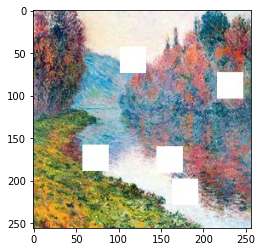

In [ ]:
plt.imshow(img)

if you don't konw the style class and the mask type, please use our classifiers:

In [ ]:
style_class_preds = monet_classifier.model(img[np.newaxis,:,:,])
style_class = np.argmax(style_class_preds)                                      # 0 = regular photos, 1 = monet
mask_type_preds = mask_classifier.model(mask[np.newaxis,:,:,])
mask_type = np.argmax(mask_type_preds)                                          # 0 = central block, 1 = blocks, 2 = region
style_class, mask_type

(1, 1)

If you know the style class and the mask type, please insert:

In [ ]:
style_class = 1 # 0 = regular photos, 1 = monet
mask_type = 1 # 0 = central block, 1 = blocks, 2 = region

according the results, fill the mask

In [ ]:
if style_class == 0:
    if mask_type == 0:
        gen_missing = centeral_block_photos_model.generator(img[np.newaxis,:,:,])
    elif mask_type == 1:
        gen_missing = blocks_photos_model.generator(img[np.newaxis,:,:,])
    else:
        gen_missing = region_photos_model.generator(img[np.newaxis,:,:,])
    
    
else:
    if mask_type == 0:
        gen_missing = centeral_block_monet_model.generator(img[np.newaxis,:,:,])
    elif mask_type == 1:
        gen_missing = blocks_monet_model.generator(img[np.newaxis,:,:,])
    else:
        gen_missing = region_monet_model.generator(img[np.newaxis,:,:,])

let's plot our results

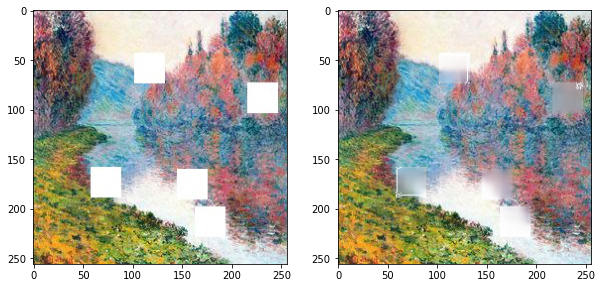

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(10, 10))
axs[0].imshow(img)
axs[1].imshow(np.where(mask<1, img, gen_missing)[0])